# Fisher Score Mixin Example

This notebook demonstrates how to use the ``qinfer.ScoreMixin`` class to develop models that use numerical differentiation to calculate the Fisher information. We test the mixin class with two examples where the Fisher information is known analytically.

## Preamble

In [1]:
from __future__ import division, print_function

In [2]:
%matplotlib inline

/home/cgranade/anaconda/envs/qinfer-binder/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from qinfer import ScoreMixin, SimplePrecessionModel, RandomizedBenchmarkingModel
import numpy as np

/home/cgranade/anaconda/envs/qinfer-binder/lib/python3.5/site-packages/qinfer/metrics.py:51: UserWarning: Could not import scikit-learn. Some features may not work.
  warnings.warn("Could not import scikit-learn. Some features may not work.")
/home/cgranade/anaconda/envs/qinfer-binder/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/home/cgranade/anaconda/envs/qinfer-binder/lib/python3.5/site-packages/qinfer/parallel.py:53: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  "Could not import IPython parallel. "


In [4]:
import matplotlib.pyplot as plt
try:
    plt.style.use('ggplot')
except:
    pass

## Simple Precession Model Test

Create two models, one that uses ScoreMixin's numerical ``score`` method, and one that uses ``SimplePrecessionModel``'s analytic ``score`` method. To make the first model, we declare a class that does nothing but inherits from both the ``ScoreMixin`` class and ``SimplePrecessionModel``; note that ``ScoreMixin`` is first, such that its implementation of ``Model.score()`` overrides that of ``SimplePrecessionModel``.

In [5]:
class NumericalSimplePrecessionModel(ScoreMixin, SimplePrecessionModel):
    pass

analytic_model = SimplePrecessionModel()
numerical_model = NumericalSimplePrecessionModel()

expparams = np.linspace(1, 10, 50)
modelparams = np.linspace(.1,1,50)[:, np.newaxis]

We verify that both models compute the same score by plotting the score for a range of experiment and model parameters. Since this is a single-parameter model, the score is a scalar.

(50, 50)
(50, 50)


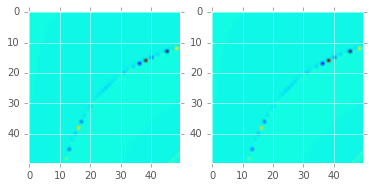

In [6]:
analytic_score = analytic_model.score(np.array([0],dtype=int),modelparams, expparams)[0,0,...]
print(analytic_score.shape)
numerical_score = numerical_model.score(np.array([0],dtype=int),modelparams, expparams)[0,0,...]
print(numerical_score.shape)

plt.subplot(1,2,1)
plt.imshow(analytic_score)
plt.subplot(1,2,2)
plt.imshow(numerical_score)

Next, we verify that both models give the same Fisher information.

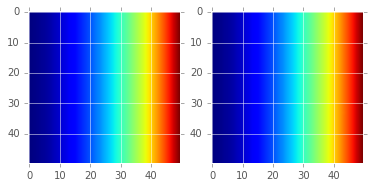

In [7]:
analytic_fisher_info = analytic_model.fisher_information(modelparams, expparams)[0,0,...]
numerical_fisher_info = numerical_model.fisher_information(modelparams, expparams)[0,0,...]

plt.subplot(1,2,1)
plt.imshow(analytic_fisher_info)
plt.subplot(1,2,2)
plt.imshow(numerical_fisher_info)

## Randomized Benchmarking Model

To test that we get multiparameter Fisher information calculations correct as well, we compare to the zeroth-order non-interlaced randomized benchmarking model.

In [8]:
class NumericalRandomizedBenchmarkingModel(ScoreMixin, RandomizedBenchmarkingModel):
    pass

analytic_model = RandomizedBenchmarkingModel()
numerical_model = NumericalRandomizedBenchmarkingModel()

We now make experiment and parameters to test with.

In [9]:
expparams = np.empty((150,), dtype=analytic_model.expparams_dtype)
expparams['m'] = np.arange(1, 151)

modelparams = np.empty((500, 3))
modelparams[:, 0] = np.linspace(0.1, 0.999, 500)
modelparams[:, 1] = 0.5
modelparams[:, 2] = 0.5

Let's make sure that the returned Fisher information has the right shape. Note that the Fisher information is a four-index tensor here, with the two indices for the information matrix itself, plus two indices that vary over the input model parameters and experiment parameters.

In [10]:
afi = analytic_model.fisher_information(modelparams, expparams)
assert afi.shape == (3, 3, modelparams.shape[0], expparams.shape[0])
nfi = numerical_model.fisher_information(modelparams, expparams)
assert nfi.shape == (3, 3, modelparams.shape[0], expparams.shape[0])

We check that each Fisher information matrix has errors that are small compared to the analytic FI alone.

In [11]:
np.linalg.norm(afi - nfi) / np.linalg.norm(afi)

1.6626103445273564e-07

Next, we plot the trace-inverse of each to check that we get the same Cramer-Rao bounds.

In [12]:
def tr_inv(arr):
    try:
        return np.trace(np.linalg.inv(arr.reshape(3, 3)))
    except LinAlgError:
        return float('inf')

In [13]:
def crb(fi):
    return np.apply_along_axis(tr_inv, 0, np.sum(fi.reshape((9, modelparams.shape[0], expparams.shape[0])), axis=-1))

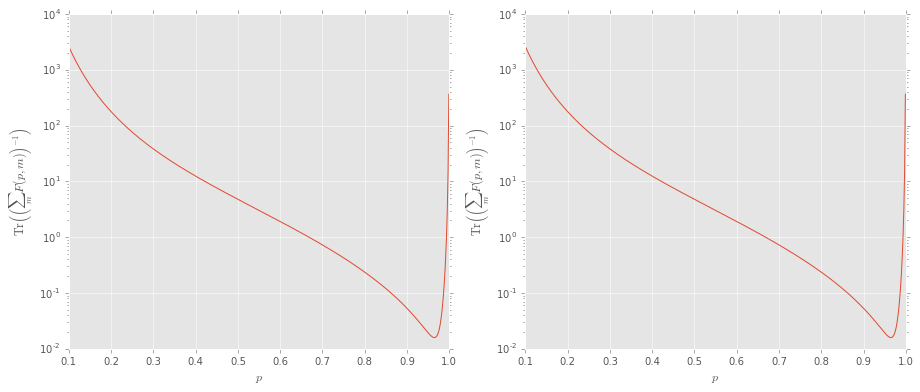

In [14]:
plt.figure(figsize=(15, 6))
for idx, fi in enumerate([afi, nfi]):
    plt.subplot(1,2, 1 + idx)
    plt.semilogy(modelparams[:, 0], crb(fi))
    plt.ylabel(r'$\operatorname{Tr}\left(\left(\sum_m F(p, m)\right)^{-1}\right)$')
    plt.xlabel('$p$')

Finally, we note that the numerical FI calculations are not much slower than the analytic calculations.

In [15]:
%timeit analytic_model.fisher_information(modelparams, expparams)
%timeit numerical_model.fisher_information(modelparams, expparams)

100 loops, best of 3: 18.4 ms per loop
10 loops, best of 3: 36.3 ms per loop
